# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [6]:
!nvidia-smi

Sat Feb 22 13:43:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [3]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
# !pip install gdown --upgrade
# !gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

--2025-02-22 12:11:44--  https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/w5r49vs5e956w6c4z6ob9/food-11.zip?rlkey=3no5l2xjiqgk2ckwbewaanm5p&dl=0 [following]
--2025-02-22 12:11:45--  https://www.dropbox.com/scl/fi/w5r49vs5e956w6c4z6ob9/food-11.zip?rlkey=3no5l2xjiqgk2ckwbewaanm5p&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaabff755104f43a57cd4f05f08.dl.dropboxusercontent.com/cd/0/inline/Ckk2QZ0qbb7ZZFwvEKGBCEnAMomKVJ06vIH-fCMPVIgeu7qZCY-VcfRvTM6nEW3Ken0ws7foPvsBx90ILsOHAGFv9lfHLEYlCVIoPQviT5ejwsQNaVzFK-38lHmY3LIuIPHpuwAT5i2QaIrZIA9DChyZ/file# [following]
--2025-02-22 12:11:46--  https://ucaabff755104f43a57cd4f05f08.dl.dropboxusercontent.co

In [4]:
! unzip food11.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/9_4311.jpg        
  inflating: train/9_4376.jpg        
  inflating: train/9_7584.jpg        
  inflating: train/9_9259.jpg        
  inflating: train/9_7284.jpg        
  inflating: train/9_1748.jpg        
  inflating: train/9_1630.jpg        
  inflating: train/9_3000.jpg        
  inflating: train/9_3252.jpg        
  inflating: train/9_3880.jpg        
  inflating: train/9_9687.jpg        
  inflating: train/9_7097.jpg        
  inflating: train/9_453.jpg         
  inflating: train/9_1685.jpg        
  inflating: train/9_5144.jpg        
  inflating: train/9_4010.jpg        
  inflating: train/9_8086.jpg        
  inflating: train/9_2881.jpg        
  inflating: train/9_6089.jpg        
  inflating: train/9_9497.jpg        
  inflating: train/9_3328.jpg        
  inflating: train/9_7954.jpg        
  inflating: train/9_4958.jpg        
  inflating: train/9_1319.jpg        
  inflating: train/9_3666.jpg        

# Import Packages

In [1]:
_exp_name = "sample"

In [2]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [3]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation. Torchvision为图像预处理、数据包装以及数据增强提供了许多有用的工具。
Please refer to PyTorch official website for details about different transforms. 有关不同转换的详细信息，请参阅PyTorch官方网站。

In [4]:
# Normally, We don't need augmentations in testing and validation. 通常，我们不需要在test和validation中进行增强。
# All we need here is to resize the PIL image and transform it into Tensor. 我们需要做的就是调整PIL图像的大小并将其转换为Tensor。
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),  # 将输入图像调整为大小为128x128像素
    transforms.ToTensor(),  # 将图像从PIL Image或NumPy ndarray转换为PyTorch张量（Tensor）
])

# However, it is also possible to use augmentation in the testing phase. 然而，在测试阶段也可以使用增强。
# You may use train_tfm to produce a variety of images and then test using ensemble methods 您可以使用train_tfm生成各种图像，然后使用集成方法进行测试
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.

    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'
数据是用名称标记的，因此我们在调用'__getitem__'时加载图像和标签

In [5]:
class FoodDataset(Dataset):
    # 初始化函数，接受路径、变换函数以及可选的文件列表
    def __init__(self, path, tfm=test_tfm, files=None):
        super(FoodDataset).__init__()  # 调用父类 Dataset 的初始化函数

        self.path = path  # 存储数据集文件夹路径
        # 从指定路径中列出所有以 .jpg 结尾的文件，并按字母顺序排序
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])

        if files != None:
            # 如果传入了一个文件列表，则使用该列表覆盖默认的文件列表
            self.files = files

        self.transform = tfm  # 存储图像变换函数，通常用于数据预处理或增强

    def __len__(self):
        # 返回数据集的大小，即文件列表的长度
        return len(self.files)

    def __getitem__(self, idx):
        # 通过索引获取数据集中的一张图片
        fname = self.files[idx]  # 获取文件名
        im = Image.open(fname)  # 使用 PIL 打开图片文件
        im = self.transform(im)  # 对图像应用预处理和增强变换（如归一化、裁剪等）

        try:
            # 尝试从文件名中提取标签，假设标签是文件名中第一部分（通过下划线分隔）
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            # 如果没有找到标签（比如测试集没有标签），则标签为 -1
            label = -1

        return im, label  # 返回处理后的图像和标签

# Model

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(

            # bottom layer
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]. nn.Conv2d()创建二维卷积层, nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.BatchNorm2d(64),  # 二维批归一化层，对每个输出通道进行归一化处理，以加速训练并提高模型的泛化能力
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]. 二维最大池化层

            # middle layer
            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            # top layer
            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )

        # 全连接块
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    # 前向传播函数
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Configurations

In [7]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 8

# If no improvement in 'patience' epochs, early stop.
patience = 5

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Dataloader

In [8]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

In [14]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.) 转发数据。（确保数据和模型在同一设备上。）
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss. 计算交叉熵损失。
        # We don't need to apply softmax before computing cross-entropy as it is done automatically. 在计算交叉熵之前，我们不需要应用softmax，因为它是自动完成的。
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first. 应首先清除上一步参数中存储的梯度。
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")




    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # 保存最佳模型
    if valid_acc > best_acc:  # 如果当前验证集准确率高于之前的最佳准确率
        print(f"Best model found at epoch {epoch}, saving model")  # 输出当前最佳模型的训练周期(epoch)
        # 只保存当前验证集准确率最佳的模型，以防止保存太多模型导致内存溢出
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt")  # 保存模型的状态字典到指定路径（仅保存模型的参数）

        best_acc = valid_acc  # 更新最佳准确率为当前验证集准确率
        stale = 0  # 重置“未改进的周期计数器”
    else:
        stale += 1  # 如果当前验证集准确率没有超过最佳准确率，则“未改进的周期计数器”增加1
        if stale > patience:  # 如果“未改进的周期计数器”超过设定的耐心值（patience），则触发早停
            print(f"No improvement {patience} consecutive epochs, early stopping")  # 输出早停信息
            break  # 退出训练循环，停止训练


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 001/008 ] loss = 0.55263, acc = 0.81359


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 001/008 ] loss = 1.31968, acc = 0.60511
[ Valid | 001/008 ] loss = 1.31968, acc = 0.60511 -> best
Best model found at epoch 0, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 002/008 ] loss = 0.42477, acc = 0.85440


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 002/008 ] loss = 1.36774, acc = 0.61144
[ Valid | 002/008 ] loss = 1.36774, acc = 0.61144 -> best
Best model found at epoch 1, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 003/008 ] loss = 0.35865, acc = 0.87450


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 003/008 ] loss = 1.44138, acc = 0.59329
[ Valid | 003/008 ] loss = 1.44138, acc = 0.59329


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 004/008 ] loss = 0.26309, acc = 0.91053


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 004/008 ] loss = 1.65744, acc = 0.60117
[ Valid | 004/008 ] loss = 1.65744, acc = 0.60117


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 005/008 ] loss = 0.18897, acc = 0.93650


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 005/008 ] loss = 1.79705, acc = 0.59244
[ Valid | 005/008 ] loss = 1.79705, acc = 0.59244


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 006/008 ] loss = 0.17803, acc = 0.93929


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 006/008 ] loss = 2.21297, acc = 0.56342
[ Valid | 006/008 ] loss = 2.21297, acc = 0.56342


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 007/008 ] loss = 0.12856, acc = 0.95442


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 007/008 ] loss = 1.67383, acc = 0.63792
[ Valid | 007/008 ] loss = 1.67383, acc = 0.63792 -> best
Best model found at epoch 6, saving model


  0%|          | 0/157 [00:00<?, ?it/s]

[ Train | 008/008 ] loss = 0.12807, acc = 0.95780


  0%|          | 0/57 [00:00<?, ?it/s]

[ Valid | 008/008 ] loss = 2.10928, acc = 0.60914
[ Valid | 008/008 ] loss = 2.10928, acc = 0.60914


# Dataloader for test

In [15]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [16]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

<ipython-input-16-b23ababdbf1e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))


  0%|          | 0/47 [00:00<?, ?it/s]

In [17]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation 增强实施
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 通过在代码中使用您选择的图像大小完成train_tfm来实现增强。
## Directly copy the following block and paste it on GradeScope after you finish the code 完成代码后，直接复制以下块并将其粘贴到GradeScope上
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times. 当多次给出相同的图像时，train_tfm必须能够产生5+个不同的结果。
### Your train_tfm in the report can be different from train_tfm in your training code. 报告中的train_tfm可能与培训代码中的train_time不同。


In [18]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128) 将图像调整为固定形状（高度=宽度=128）
    transforms.Resize((128, 128)),
    # You can add some transforms here. 您可以在此处添加一些转换。
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation 视觉表示实现
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 通过在顶层和中间层的输出上实现t-SNE（t-分布随机邻居嵌入），在验证集上可视化CNN模型的学习视觉表示（您需要提交2张图像）。


In [9]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model) # 输出model（包含其结构）

<ipython-input-9-42a871132903>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{_exp_name}_best.ckpt")


Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


100%|██████████| 57/57 [00:17<00:00,  3.29it/s]


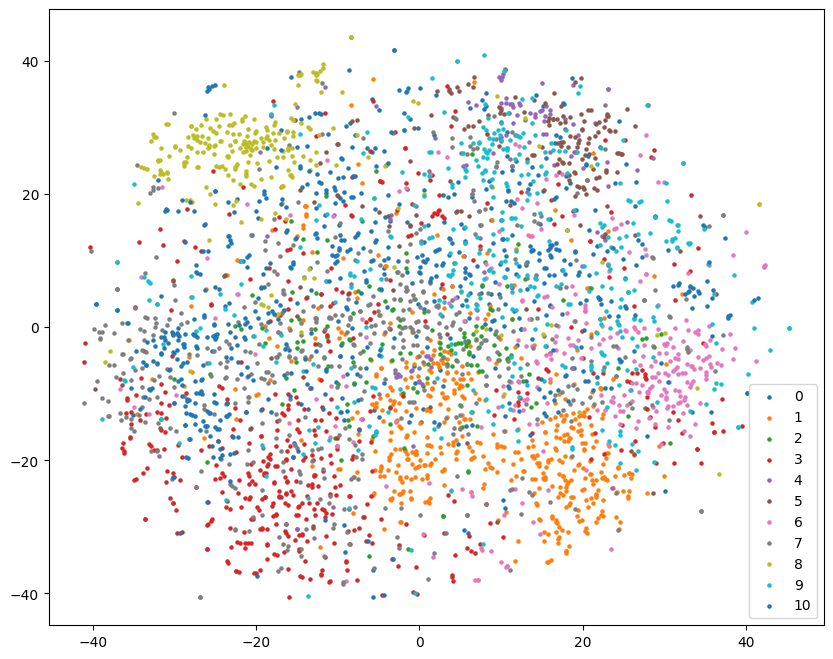

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3643 but corresponding boolean dimension is 1

<Figure size 1000x800 with 0 Axes>

In [11]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 21 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model. 你应该找出被定义为模型“顶层”或“中层”的层的索引。
# 案例有20层，index=20+1=21

features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
labels = [0]
for label in np.unique(labels):
    # plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5) # 原代码，有误
    plt.scatter(features_tsne[np.array(labels) == label, 0], features_tsne[np.array(labels) == label, 1], label=label, s=5) # 修改后代码，依旧有误
plt.legend()
plt.show()